# Sherpa Digital Brain Technical Task

## Setup Instructions

*Git instructions*

## Task

*Task instructions*


In [7]:
# Git magic to copy additional folders from github repo

REPO_URL = "https://github.com/Charter-AI/sherpa-digital-brain-technical-task.git"
REPO_NAME = "sherpa-digital-brain-technical-task"
REPO_PATH = f"/content/{REPO_NAME}"

import os

# Clone only if the repo folder doesn't already exist
if not os.path.exists(REPO_PATH):
    print(f"Cloning {REPO_URL} into {REPO_PATH}")
    os.chdir('/content')
    !git clone $REPO_URL
    os.chdir(REPO_PATH)
else:
    print(f"Repo '{REPO_NAME}' already exists at {REPO_PATH}. \nSkipping clone and pulling instead...")
    os.chdir(REPO_PATH)
    !git pull

# Confirm it worked
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))


# Used later to make all references line up
project_root = os.getcwd()

Repo 'sherpa-digital-brain-technical-task' already exists at /content/sherpa-digital-brain-technical-task. 
Skipping clone and pulling instead...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 3 (delta 1), reused 1 (delta 1), pack-reused 2 (from 1)
Unpacking objects: 100% (3/3), 1.45 KiB | 1.45 MiB/s, done.
From https://github.com/Charter-AI/sherpa-digital-brain-technical-task
   2ae689b..092a505  main       -> origin/main
Updating 2ae689b..092a505
Fast-forward
 ...ves-AI-and-GenAI-in-Customer-Engagement-EP8-4Dec2024.pdf | Bin
 ...CEOs-Guide-to-Maximizing-Value-from-AI-EP0-3July2024.pdf | Bin
 ...ives-Future-of-Data-Management-with-AI-EP9-10Dec2024.pdf | Bin
 ...in Retail_ The Gen AI Tipping Point _ Bain & Company.pdf | Bin
 ... Debate_ Will Agentic AI Kill SaaS_ _ Bain & Company.pdf | Bin
 .../What Boards Need to Do About AI _ Bain & Company.pdf    | Bin
 documents/{BCG => }/ai-maturity-matrix-nov-2024.pdf         | Bin
 documents/{BCG 

In [15]:
# Install dependencies
# Takes ~2min

%pip install numpy
%pip install torch
%pip install openai
%pip install python-dotenv

!apt-get install -y poppler-utils

%pip install byaldi
%pip install flash-attn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [16]:
# Import dependencies
import os
import sys
import torch
import base64

import numpy as np
from dotenv import load_dotenv

from openai import AzureOpenAI
from byaldi import RAGMultiModalModel
from IPython.display import display
from IPython.display import Image as IPythonImage

In [17]:
# LLM functions (OpenAI GPT)
load_dotenv()

# Access environment variables
AZURE_OPENAI_MODEL = os.getenv("AZURE_OPENAI_MODEL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_VERSION = os.getenv("AZURE_OPENAI_VERSION")

openai_client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
)


def query_llm(
        query: str,
        system_prompt: str = "You are a helpful assistant.",
        b64_images: list[str] | None = None,
        raw_output: bool = False
) -> str:
    user_content = [{"type": "text", "text": query}]

    # Send b64 images to LLM if provided
    if b64_images is not None:
        user_content.extend([
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{b64_image}"
                }
            } for b64_image in b64_images
        ])

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_content}
    ]

    raw_response = openai_client.chat.completions.create(
        model=AZURE_OPENAI_MODEL,
        messages=messages,
        temperature=0.0
    )

    if raw_output:
        return raw_response
    else:
        return raw_response.choices[0].message.content


OpenAIError: Missing credentials. Please pass one of `api_key`, `azure_ad_token`, `azure_ad_token_provider`, or the `AZURE_OPENAI_API_KEY` or `AZURE_OPENAI_AD_TOKEN` environment variables.

In [19]:
# Byaldi functions
default_index = "default_index"

def initialise_rag_model(index_name: str = default_index) -> RAGMultiModalModel:
    """
    Initialises the RAG model with index stored at `.byaldi/<index_name>`.
    If index does not exist, index will be created.
    If index does exist, it will be loaded.
    """
    rag_model = None

    # Use CUDA if available, otherwise use CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # If .byaldi/<index_name> folder exists, load index from there
    # Otherwise, load generic model with vidore/colqwen2-v1.0 vision model

    index_path = project_root + "/.byaldi/" + index_name
    if os.path.exists(index_path):
        rag_model = RAGMultiModalModel.from_index(index_path, device=device)
    else:
        rag_model = RAGMultiModalModel.from_pretrained(
            "vidore/colqwen2-v1.0",
            device=device
        )

    return rag_model

def index_documents(rag_model: RAGMultiModalModel, index_name: str = default_index, docs_folder_name: str = "documents"):
    """
    Indexes documents for RAG model in `docs_folder_name` and stores index at `.byaldi/<index_name>`.
    If index already exists, it will be overwritten.
    """
    index_path = project_root + "/.byaldi/" + index_name
    docs_path = project_root + "/" + docs_folder_name

    # Check if documents folder exists
    if not os.path.exists(docs_path):
        raise FileNotFoundError(f"Documents folder {docs_path} does not exist")

    rag_model.index(
        input_path=docs_path,
        index_name=index_name,
        store_collection_with_index=True,    # Store base64 encodings of documents with index
        max_image_height=2048,
        max_image_width=2048,
        overwrite=True
    )

def query_rag_model(rag_model: RAGMultiModalModel, query: str, k: int = 5):
    """
    Queries the RAG model with `query` and returns `k` most relevant documents.

    Returns a list of dictionaries, each containing the following keys:
    - `doc_id`: ID of document
    - `page_num`: Page number of image within document
    - `score`: Score of document
    - `metadata`: Metadata attached to image
    - `base64`: Base64 encoded image
    """
    results = rag_model.search(
        query=query,
        k=k
    )

    results_dict = [x.__dict__ for x in results]
    return results_dict


In [11]:
# Index all files in /documents folder
# Takes ~55mins on T4 GPU
rag_model = initialise_rag_model()
index_documents(rag_model)

Using device: cuda
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Indexing file: /content/sherpa-digital-brain-technical-task/documents/infographic-what-deepseek-means-for-data-center-investment-risk.pdf
Added page 1 of document 0 to index.
Index exported to .byaldi/default_index
Indexing file: /content/sherpa-digital-brain-technical-task/documents/ai-maturity-matrix-nov-2024.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 to index.
Added page 14 of document 1 to index.
Added page 15 of document 1 to index.
Added page 16 of document 1 to index.
Added page 17 of document 1 to index.
Added page 18 of document 1 to index.
Added pa

Using device: cuda
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 574 images from 2 JSON files.
Retreived page 6 from document 15 with score 20.125


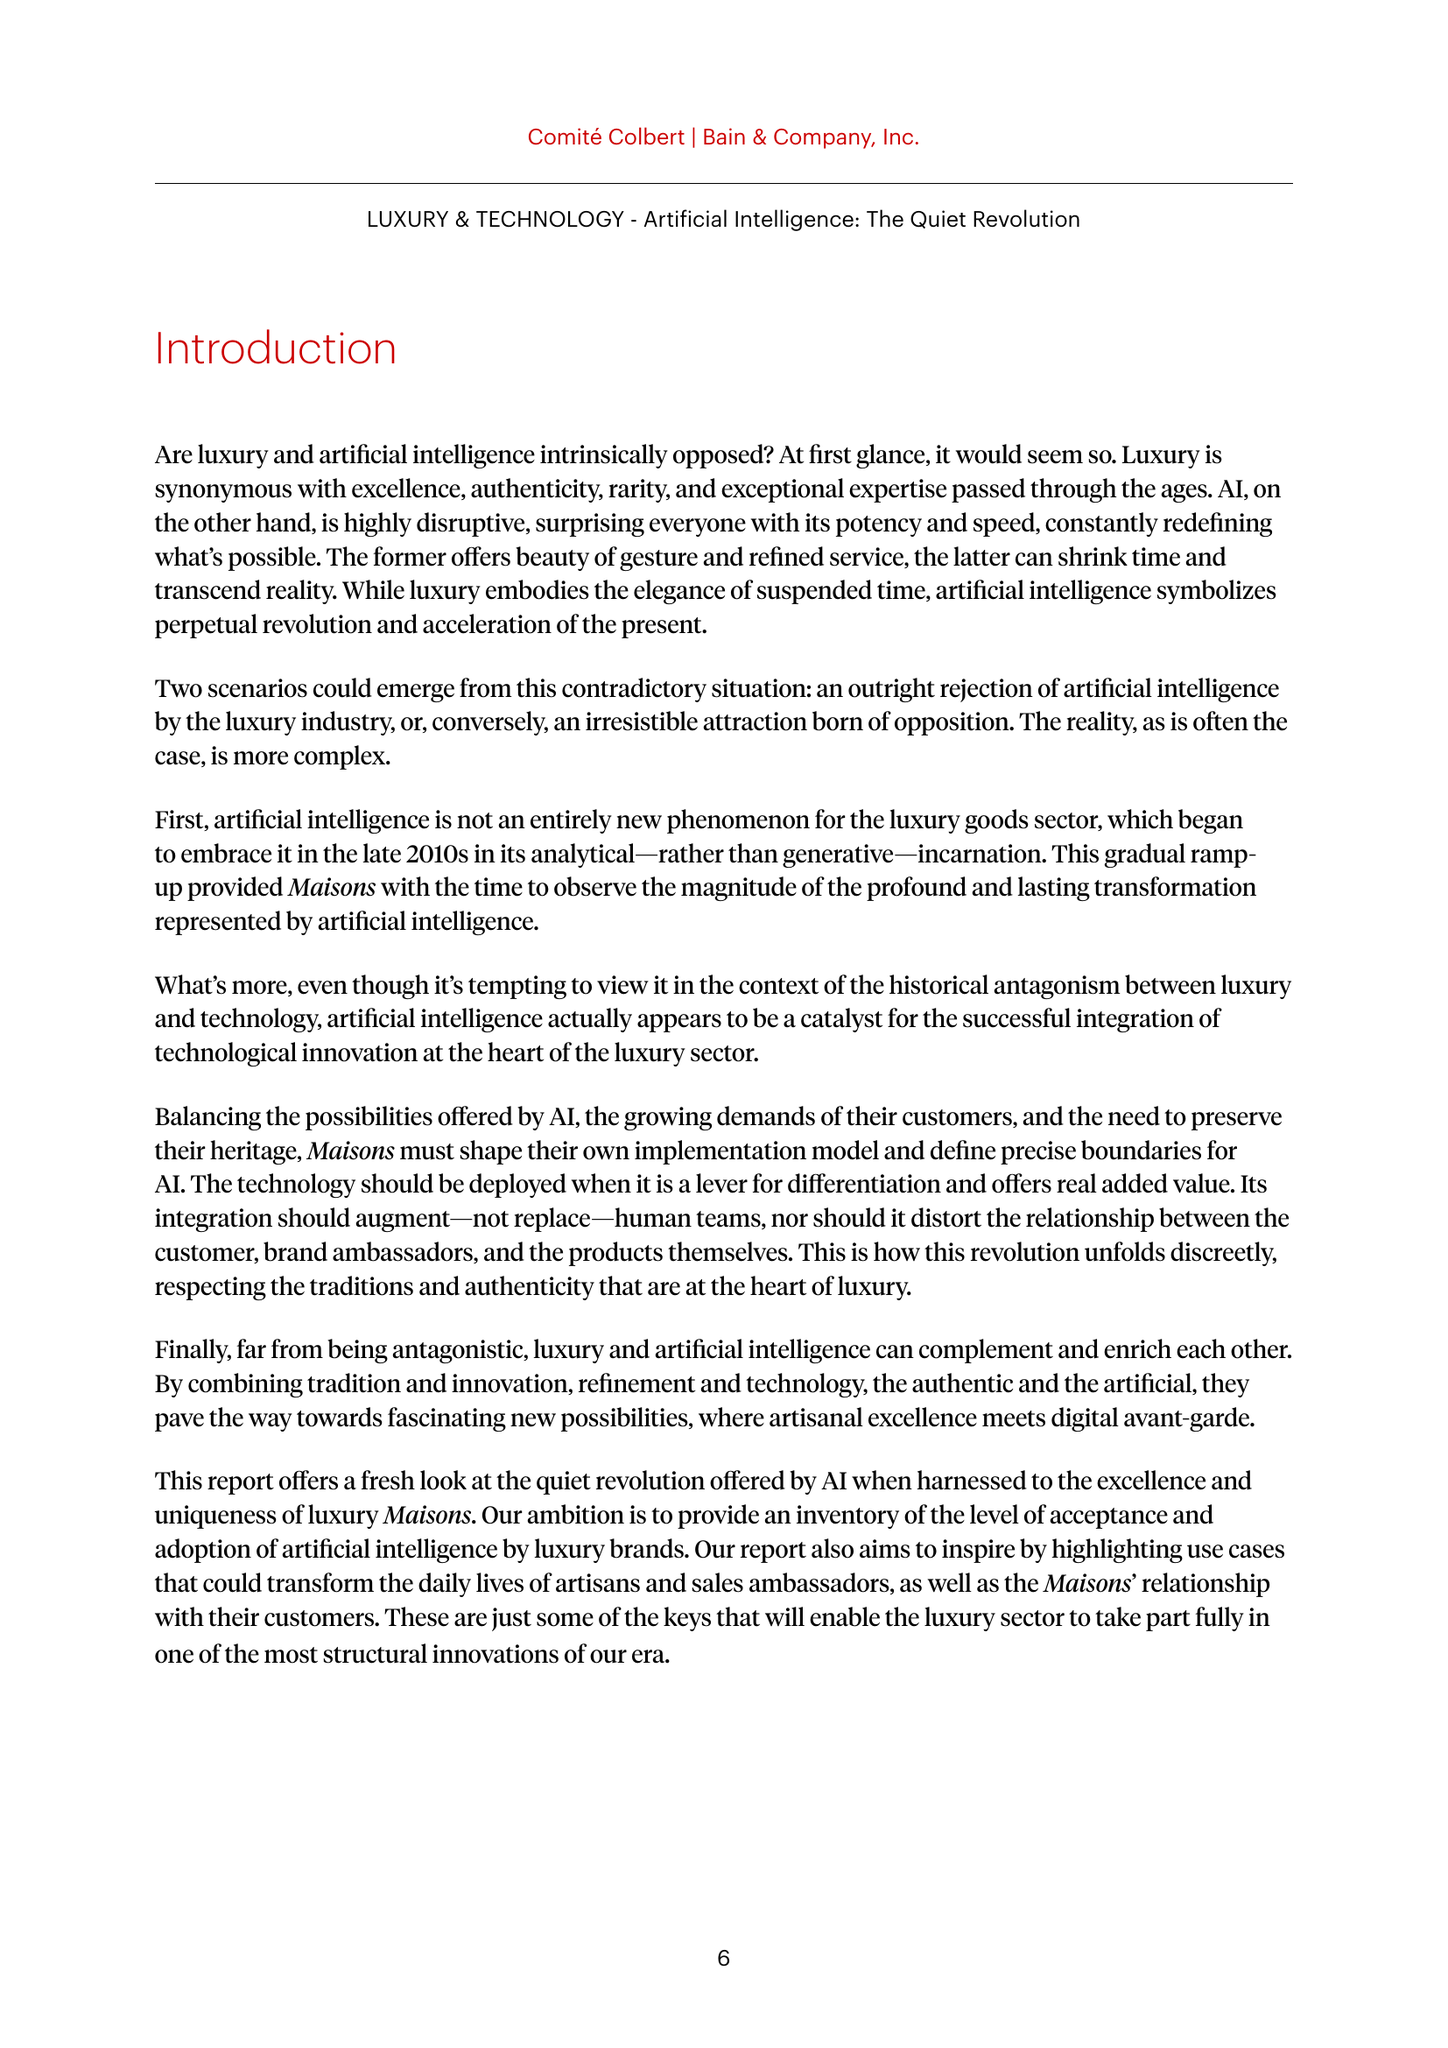

Retreived page 20 from document 15 with score 19.75


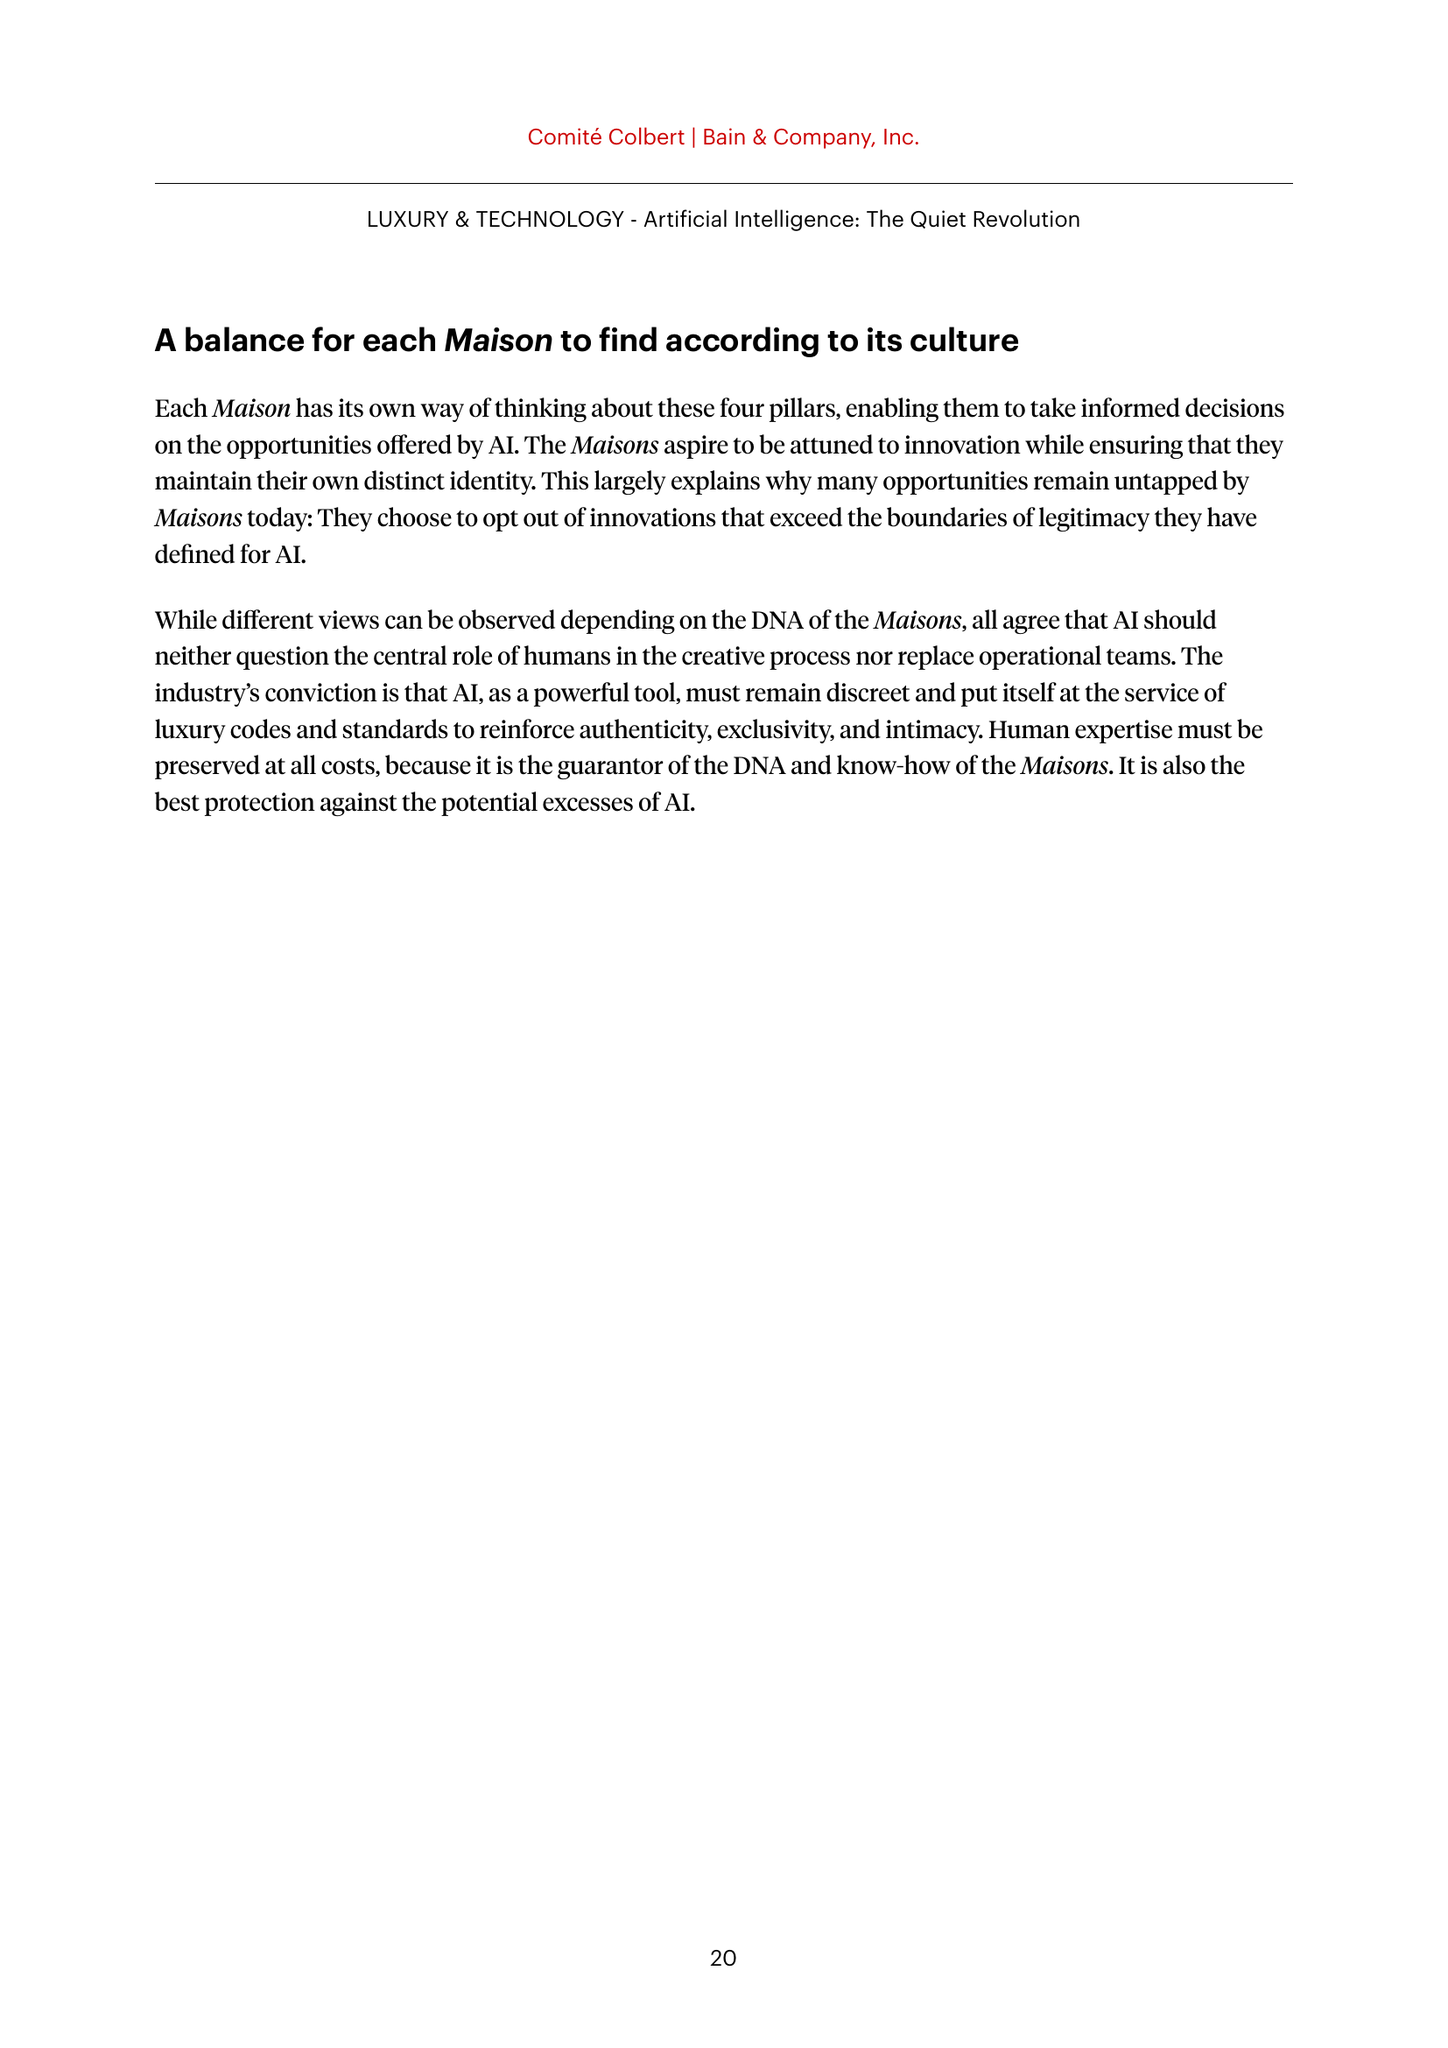

Retreived page 27 from document 15 with score 19.75


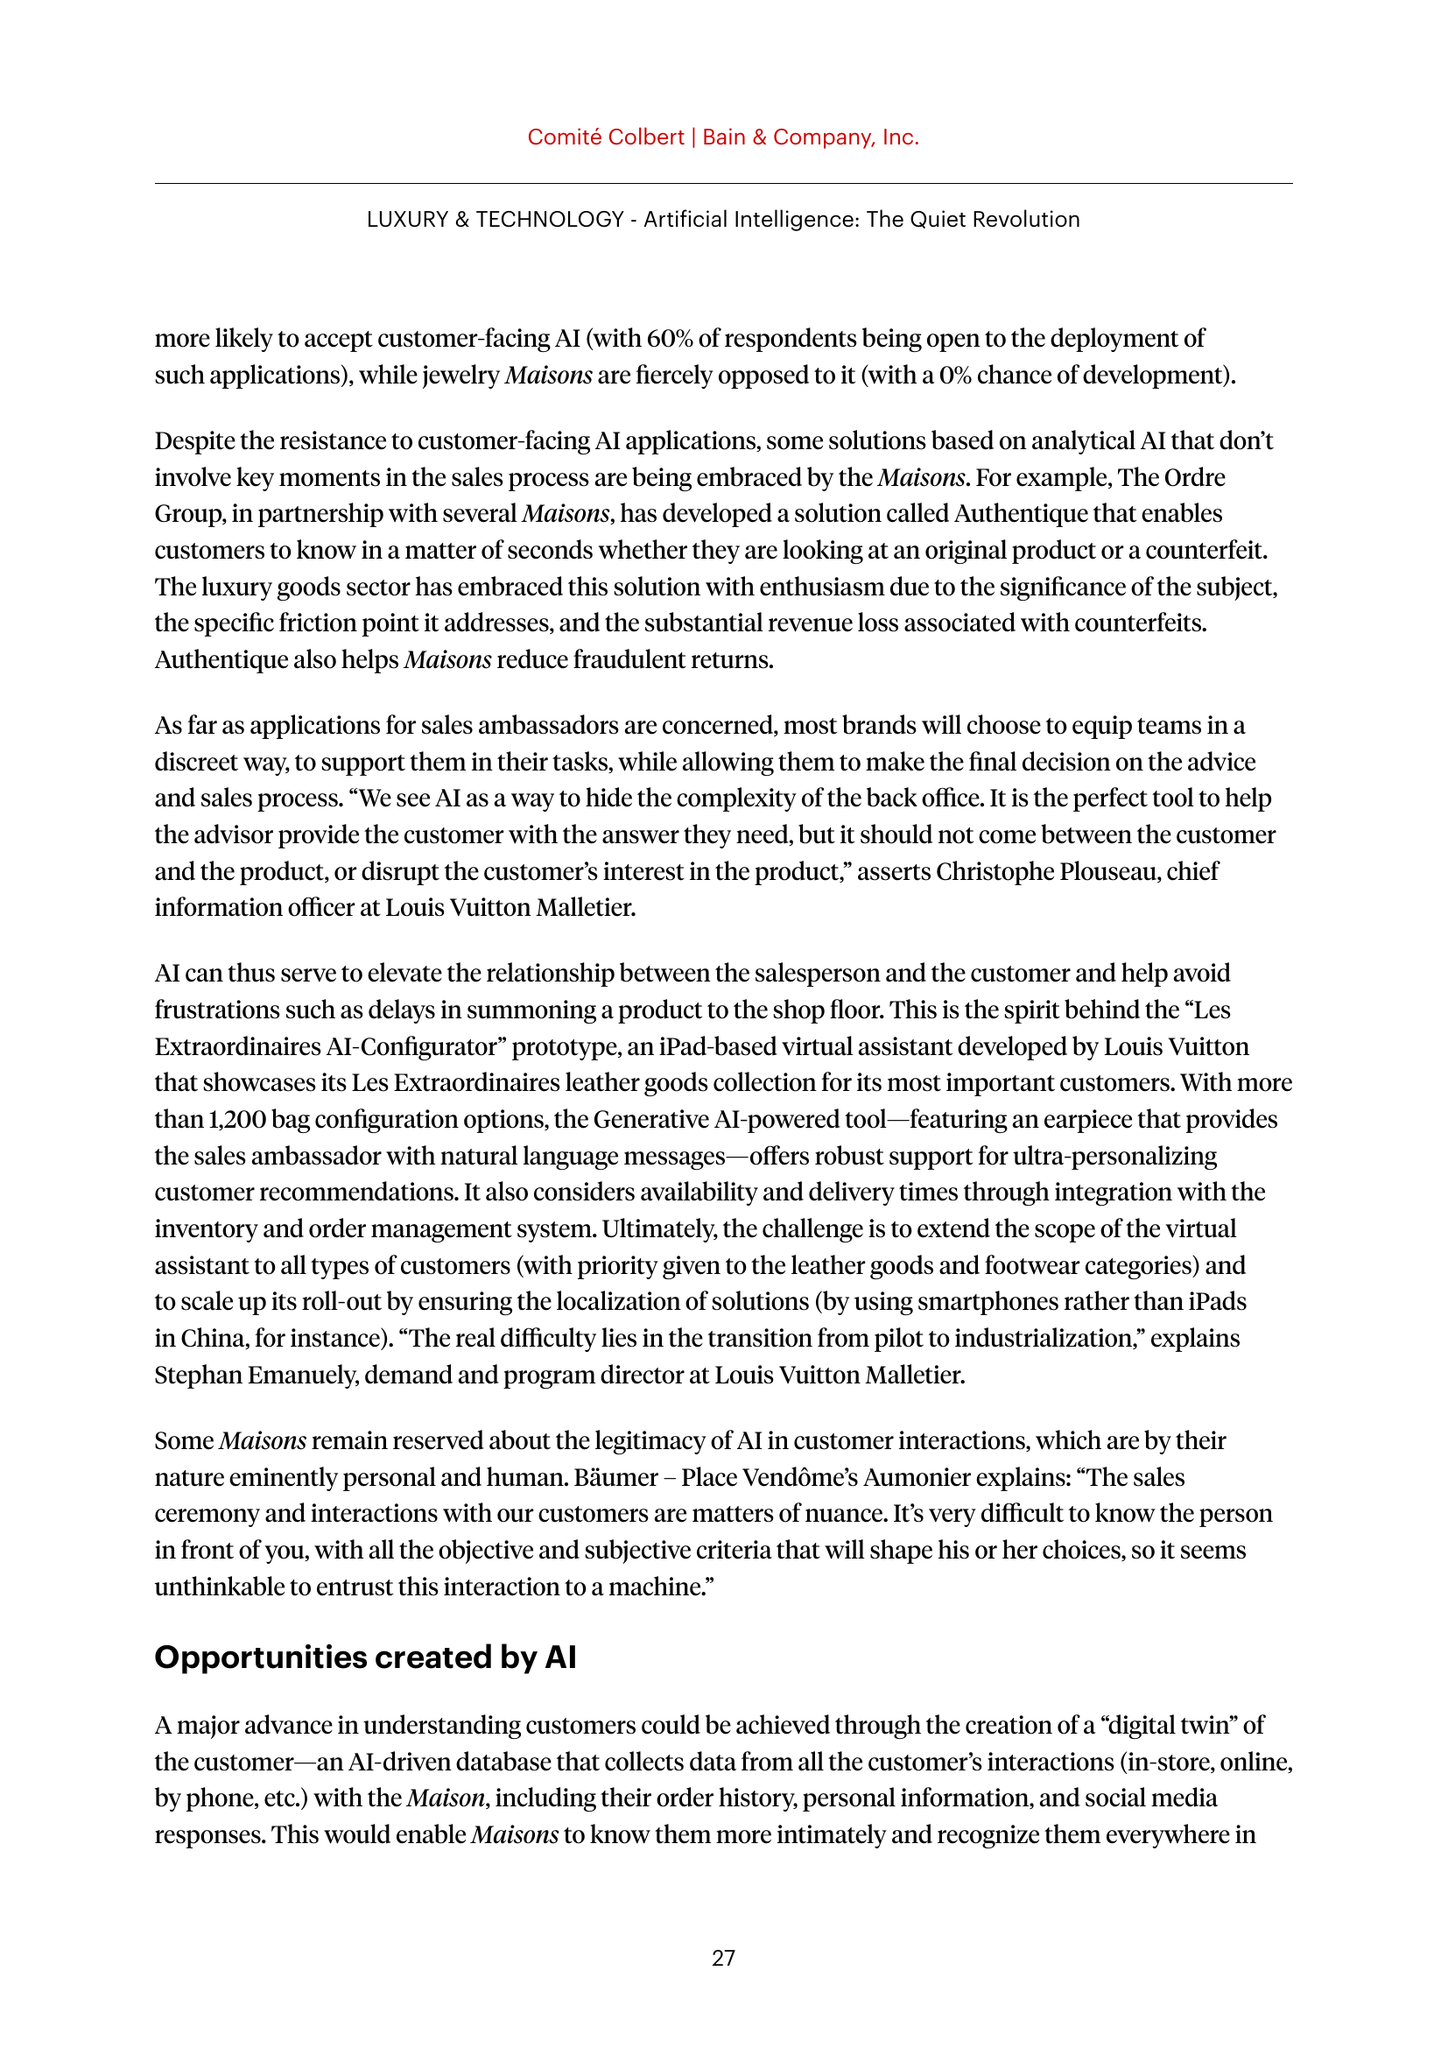

Retreived page 5 from document 15 with score 19.5


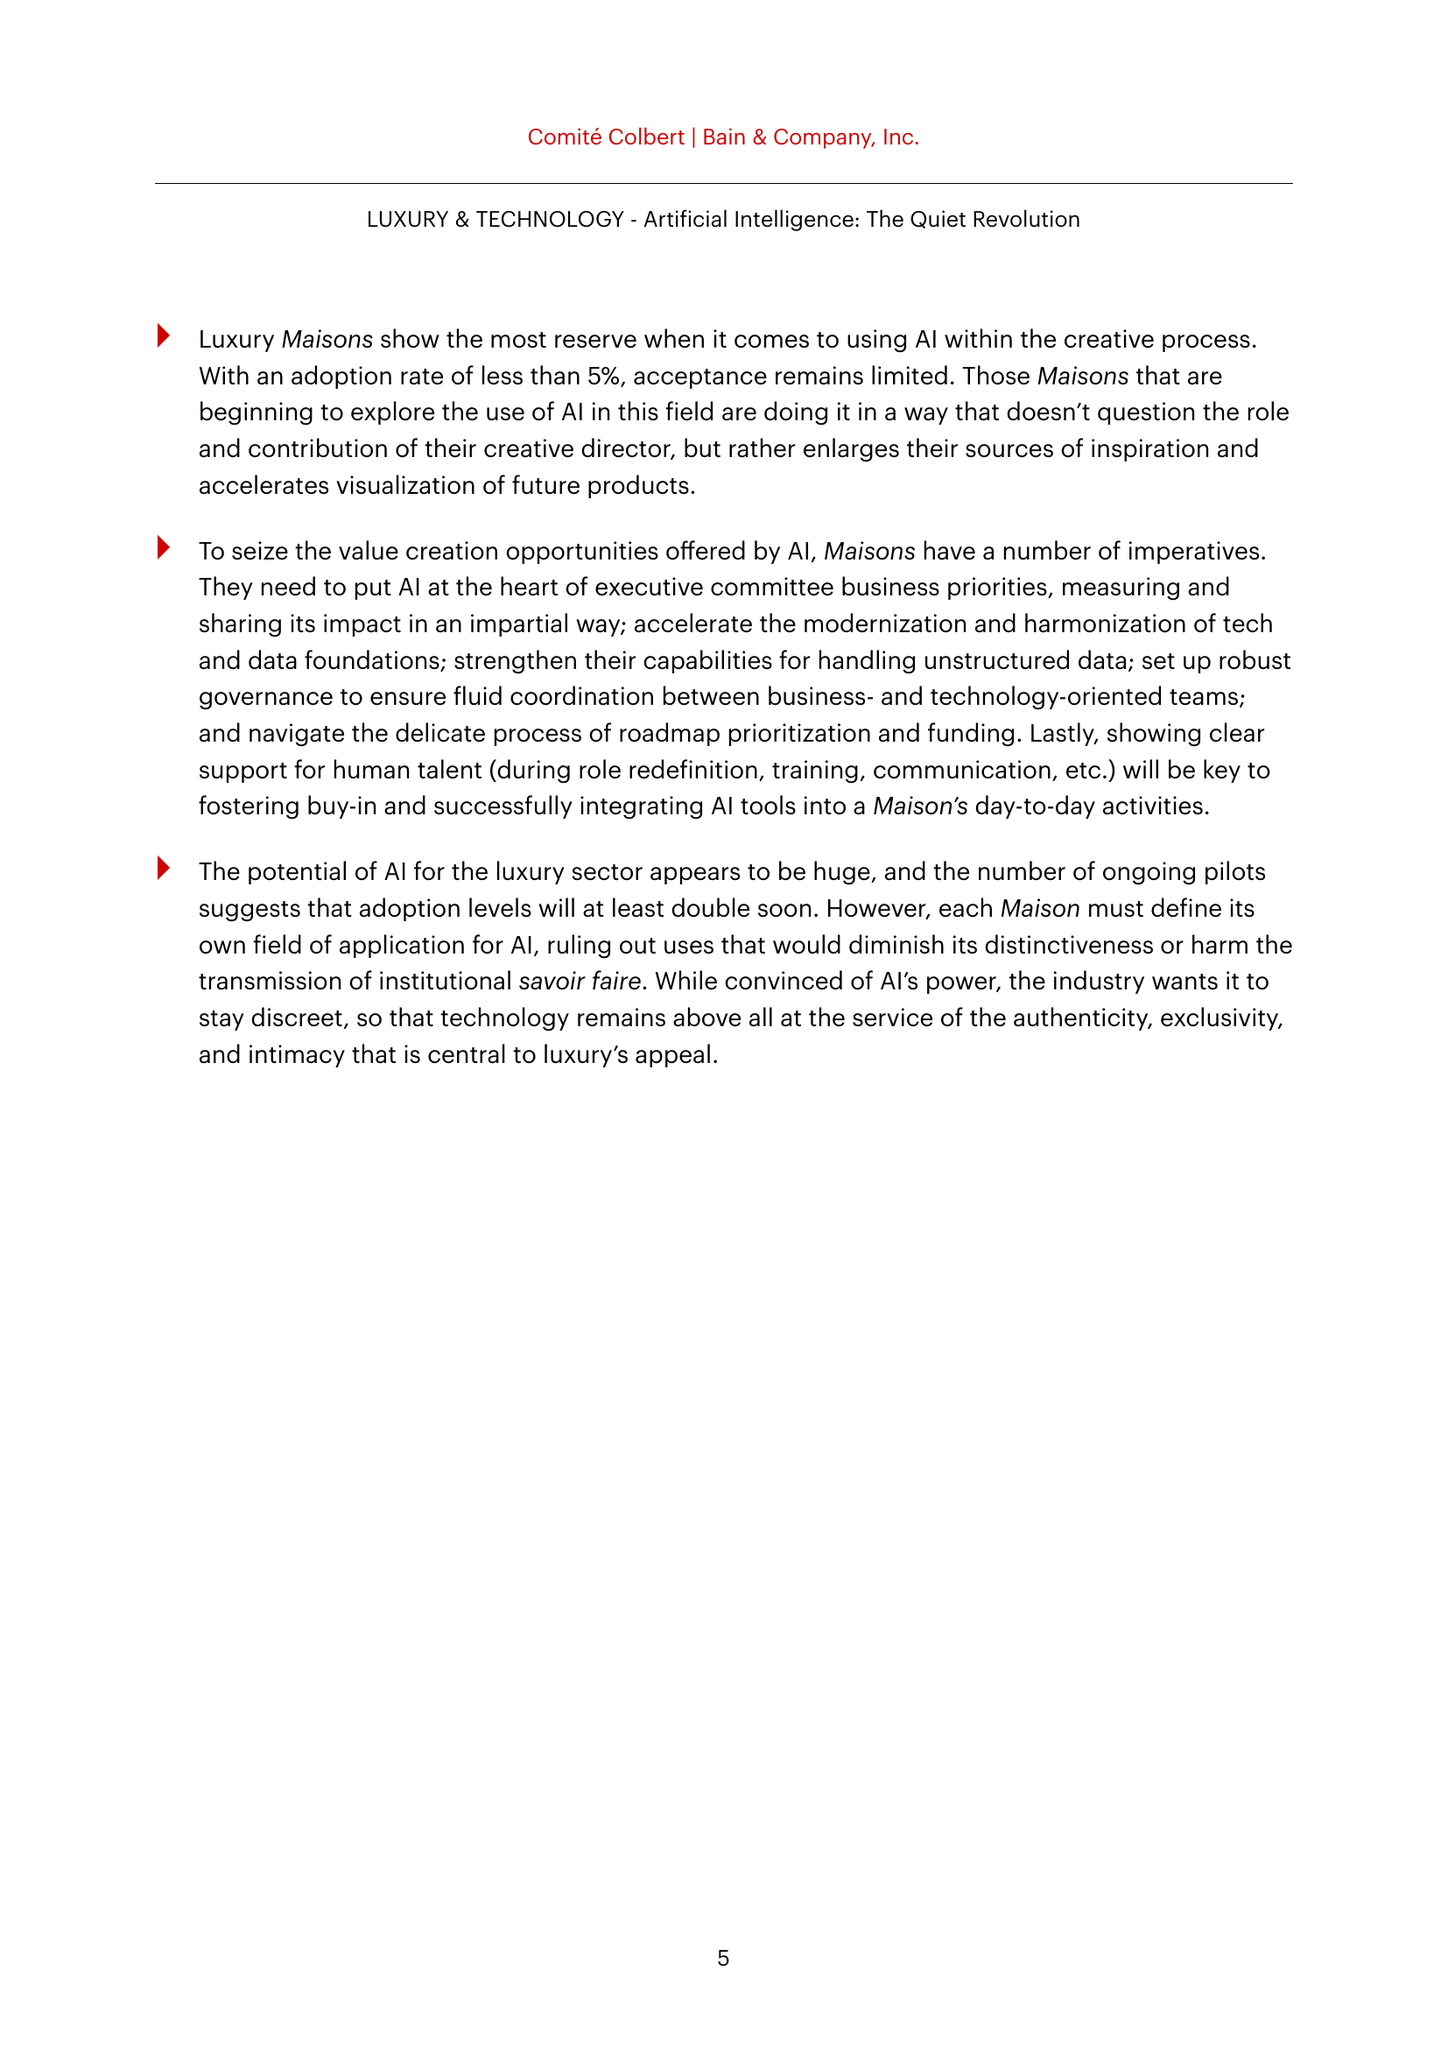

Retreived page 25 from document 15 with score 19.25


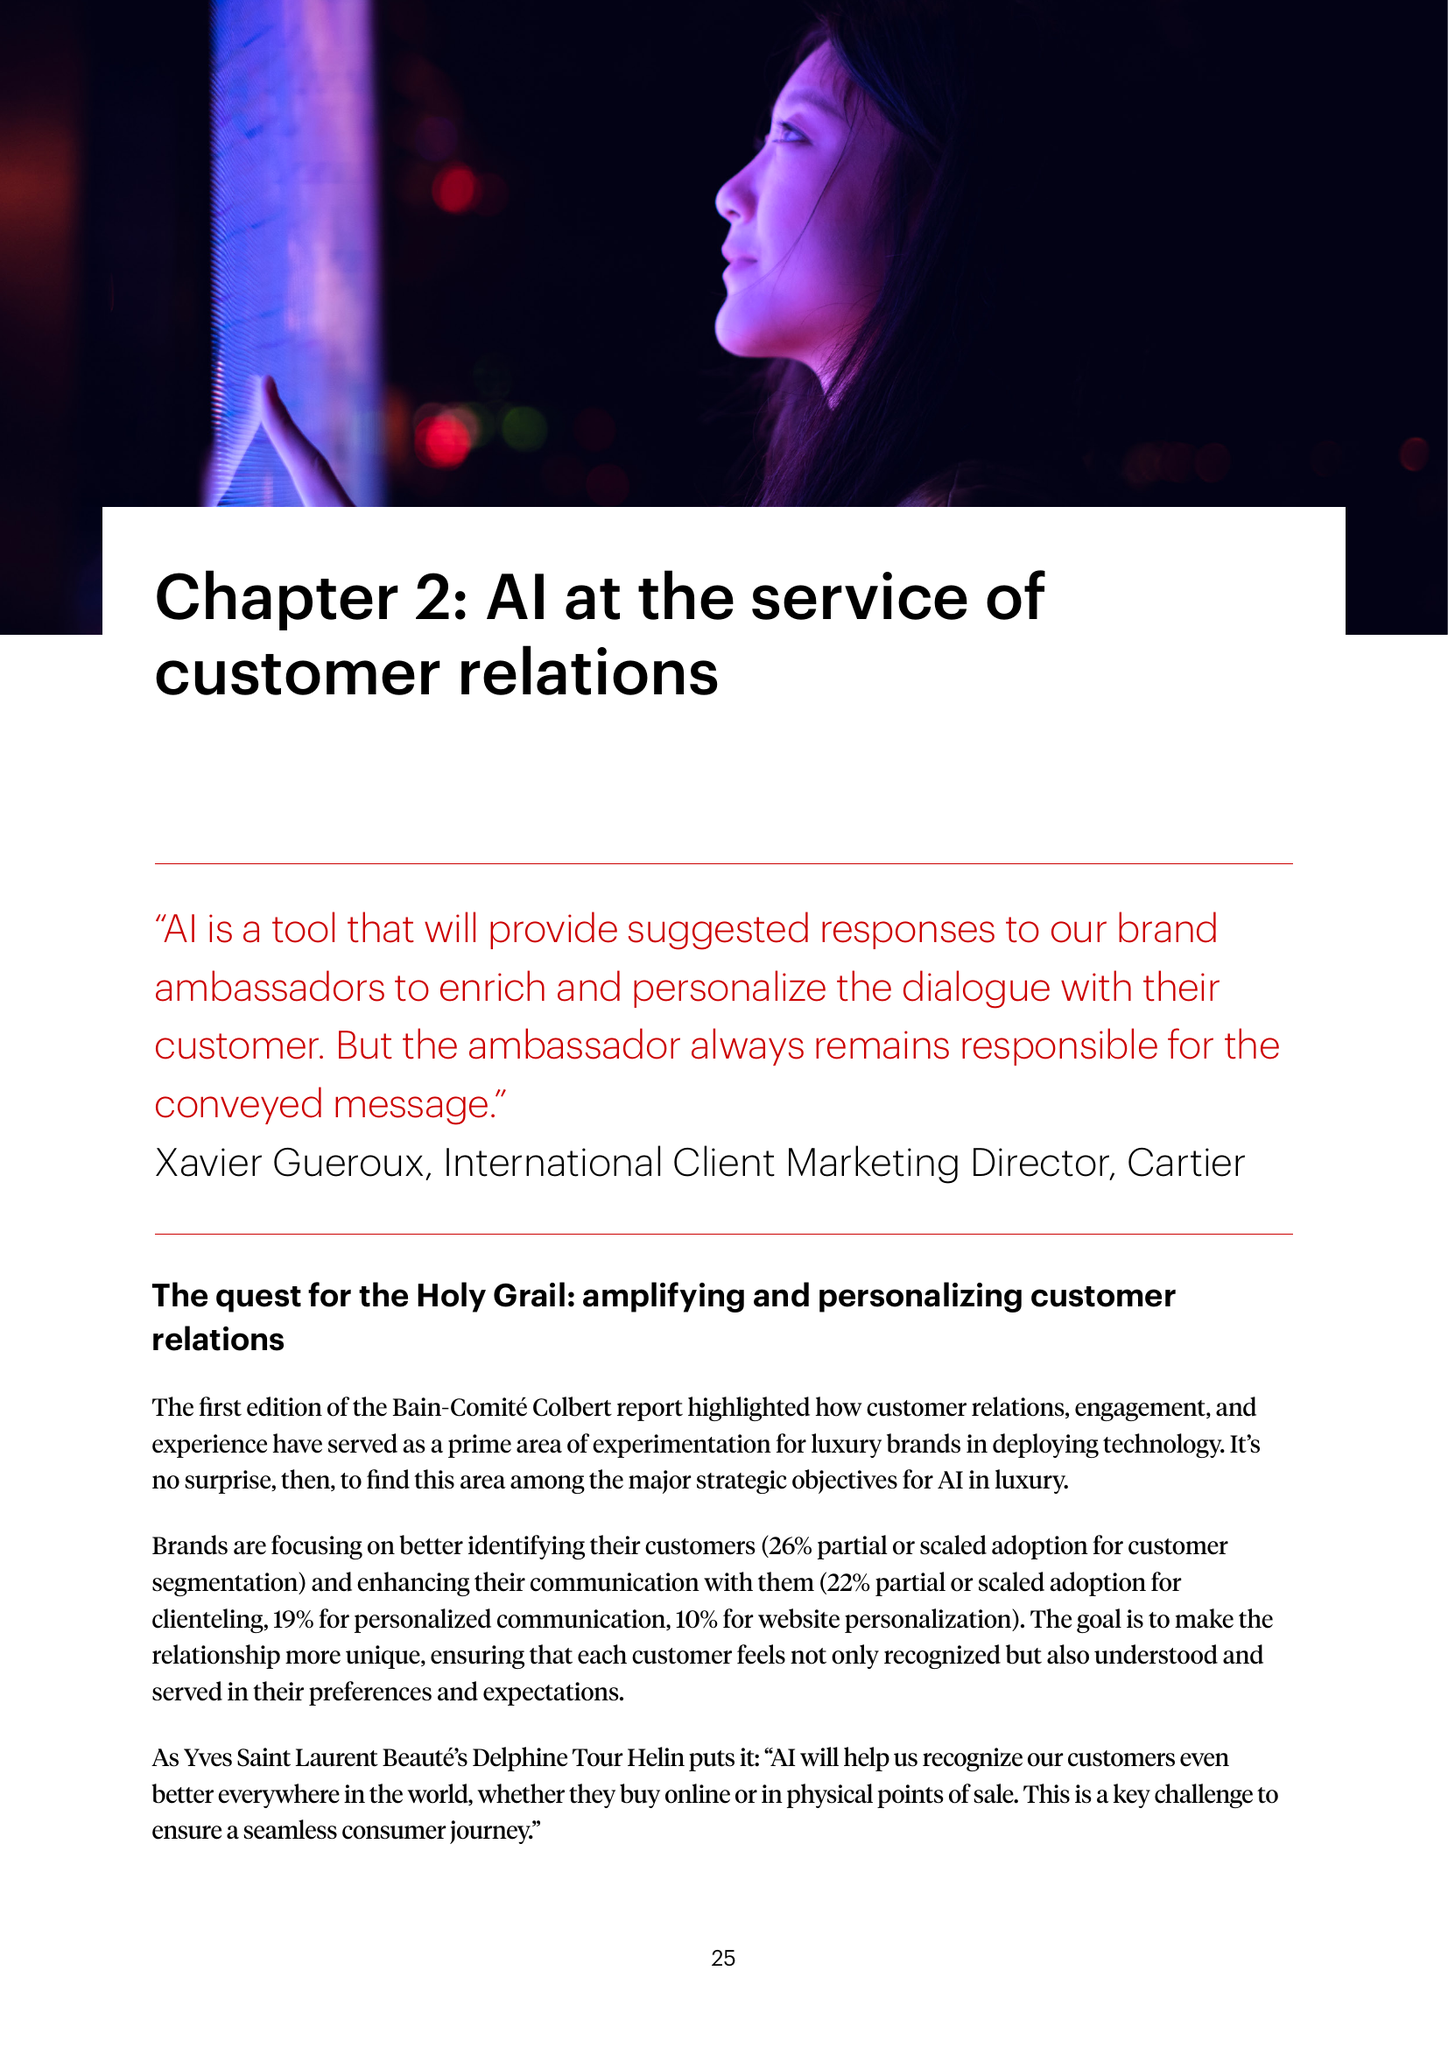

In [21]:
# Query RAG model and display retrieved images
example_query = "Who at Bain and Company is best suited to understand the intersection of AI and the luxury industry"

rag_model = initialise_rag_model()
results = query_rag_model(rag_model, example_query)
images = [result["base64"] for result in results]

for result in results:
    print(f"Retreived page {result['page_num']} from document {result['doc_id']} with score {result['score']}")
    display(IPythonImage(data=base64.b64decode(result["base64"])))

In [ ]:
llm_response = query_llm(example_query, b64_images=images)
print(llm_response)